In [36]:
import sys
import os
import numpy as np 
import pandas as pd
import numpy.matlib


import matplotlib.pyplot as plt
from scipy.integrate import odeint

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import torch
import time
import cvxpy as cp
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

## Generate data points $X$

In [2]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Function to generate clustered data
def generate_clusters(total_points, cluster_percentages):
    """
    Generate clustered data based on specified percentages for each cluster.

    :param total_points: Total number of data points to generate.
    :param cluster_percentages: List of percentages for each cluster (should sum to 1).
    :return: Array of generated points.
    """
    # Validate that percentages sum to 1
    if not np.isclose(sum(cluster_percentages), 1.0):
        raise ValueError("Cluster percentages must sum to 1.")

    # Define the cluster centers
    cluster_centers = [(1, 1), (5, 5), (9, 1)]
    
    # Variance of clusters
    cluster_variance = [0.5, 0.3, 0.4]
    
    if len(cluster_percentages) != len(cluster_centers):
        raise ValueError("The number of cluster percentages must match the number of cluster centers.")
    
    # Initialize an empty array for all points
    X = np.empty((0, 2), dtype=float)

    # Generate points for each cluster based on percentages
    for center, variance, percentage in zip(cluster_centers, cluster_variance, cluster_percentages):
        points_per_cluster = int(total_points * percentage)
        # Generate points from a multivariate normal distribution
        points = np.random.multivariate_normal(mean=center, cov=[[variance, 0], [0, variance]], size=points_per_cluster)
        X = np.vstack((X, points))
    
    return X

# Specify the total number of data points
total_points = 300

# Specify the percentages for each cluster (must sum to 1)
cluster_percentages = [0.2, 0.5, 0.3]

# Generate the data
X_init = generate_clusters(total_points, cluster_percentages)


## Regular Clustering Approach 

In [3]:
m = 3
Y = np.mean(X_init,axis = 0)*np.ones((m,2))

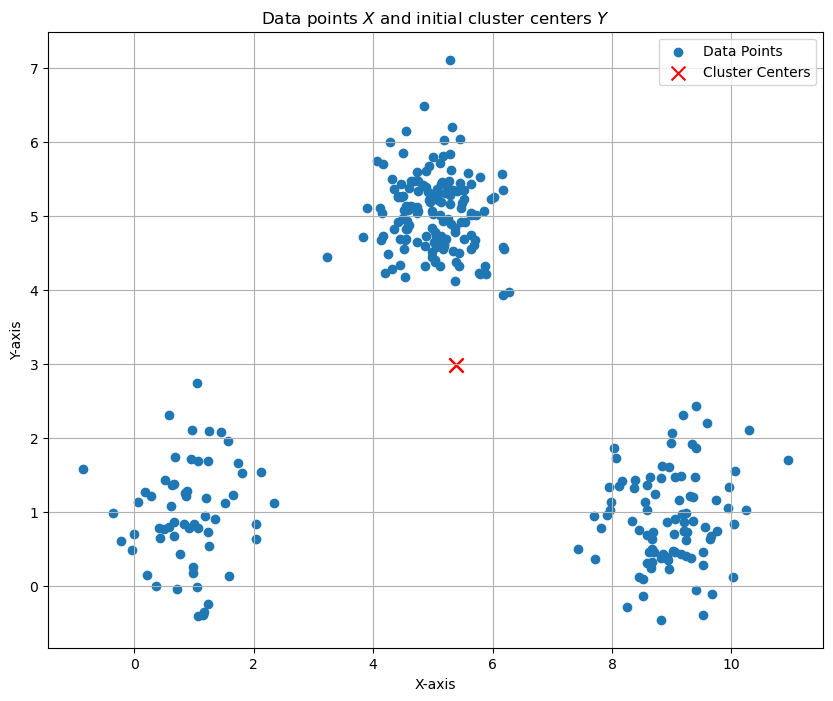

In [4]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title("Data points $X$ and initial cluster centers $Y$")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show() 

In [5]:
def cluster_beta(X_init,Y_init,m,beta,pert):
    N = np.shape(X_init)[0]
    Y_init += pert * (np.arange(m)+1).reshape(-1,1) * np.ones((m,2))
    X_expanded = np.expand_dims(X_init, 1)  # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y_init, 0)       # Shape (1, m, 2)

    # Compute the squared differences, sum over the coordinate axis (axis=2), and take the square root
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
    Y_c = P_xy.T @ X_init
    return Y_c, P_yx, P_xy

In [6]:
def clustering(X_init,m,pert,beta_final,alpha):
    beta = 0.01
    Y_init = np.mean(X_init,axis = 0)*np.ones((m,2))
    while beta <= beta_final:
        Y, P_yx, P_xy = cluster_beta(X_init,Y_init,m,beta,pert)
        beta *= alpha 
        Y_init = Y
        
    return Y, P_yx

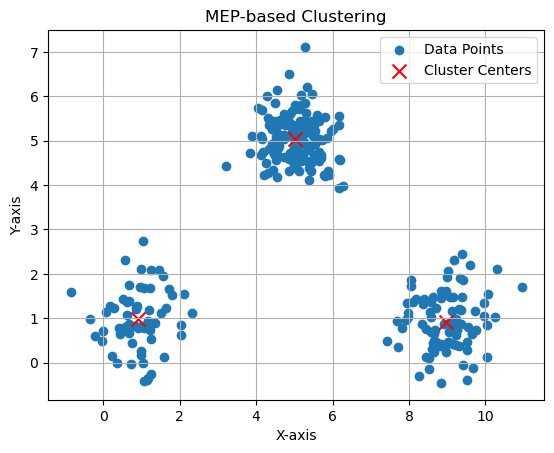

In [146]:
pert = 10e-10
m = 3
beta_final = 10
alpha = 1.05
Y_c, P_yx_c = clustering(X_init,m,pert,beta_final,alpha)
plt.scatter(X_init[:,0], X_init[:,1], label='Data Points')
plt.scatter(Y_c[:, 0], Y_c[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title(f"MEP-based Clustering")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show()

## Free Energy Function and Its Time Derivative

In [8]:
def Free_Energy(X, Y, q, P_ylx, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))

    return F

In [9]:
def Free_Energy_ver2(X, Y, q, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    Px = np.diag(q)
    P_ylx_G = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    Py = np.sum(Px @ P_ylx_G, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx_G, distances + 1/beta * np.log(P_ylx_G)))

    return F

In [10]:
def F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))
    F_shifted = F + 1/beta * np.log(m)

    # Time derivatives
    ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
    dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx.T @ Px @ X_init)
    dotF_y = cp.sum(cp.multiply(dFdY,u_y))

    ## w.r.t P_{y|x}: \sum_{i,j} dF/dp_{j|i} v_ij
    dotF_p = cp.sum(cp.multiply(Px @ (distances + 1/beta * np.log(P_ylx) + 1/beta), u_p))

    ## w.r.t beta: (1/beta)^2 H
    dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx, np.log(P_ylx)))
    dotF_beta = dFdb * u_b

    # Total time derivative
    Fdot = dotF_y + dotF_p + dotF_beta

    return F_shifted, Fdot

In [11]:
def F_Fdot_clustering_ver2(X, Y, q, u_y, u_b, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    Px = np.diag(q)
    P_ylx_G = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    Py = np.sum(Px @ P_ylx_G, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx_G, distances + 1/beta * np.log(P_ylx_G)))
    F_shifted = F + 1/beta * np.log(m)

    # Time derivatives
    ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
    dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx_G.T @ Px @ X_init)
    dotF_y = cp.sum(cp.multiply(dFdY,u_y))

    ## w.r.t beta: (1/beta)^2 H
    dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx, np.log(P_ylx)))
    dotF_beta = dFdb * u_b

    # Total time derivative
    Fdot = dotF_y + dotF_beta

    return F_shifted, Fdot

## Control Barrier Functions

In [12]:
def h_hdot(P_ylx, u_p):
    h = P_ylx * (1 - P_ylx)
    hdot = cp.multiply((1 - 2 * P_ylx), u_p)
    return h, hdot

In [13]:
def l_ldot(c, q, P_ylx, u_p):
    l = c - np.dot(q, P_ylx)
    ldot = - (q[:,np.newaxis].T @ u_p).flatten()
    return l, ldot

## Optimization Step

In [94]:
# Set parameters
N = total_points
q = 1/N * np.ones(N)
Px = np.diag(q)
res = 1e-5

# Fix the random seed for reproducibility
np.random.seed(4)

# Initialization of the decision variables
# Y = np.mean(X_init,axis = 0)*np.ones((m,2)) + res * np.random.rand(m,2)
Y = 10 * np.random.rand(m,2)

# P_ylx = np.random.rand(N, m)
# P_ylx = P_ylx / P_ylx.sum(axis=1, keepdims=True)
P_ylx = 1/m * np.ones((N,m))

Py = np.sum(Px @ P_ylx, axis = 0)
c = 1 * np.ones(m) + res

In [95]:
# Check whether the capacity constraint is satisfied

c - Py # all the elements must be non-negative

array([0.66667667, 0.66667667, 0.66667667])

In [96]:
# Decision variables 
u_p = cp.Variable((N,m))
u_y = cp.Variable((m,2))  
delta = cp.Variable(1)

# Constant parameters of the QP
p = 1000
gamma = 1
alpha_h = 10
alpha_l = 10
u_b = 0
beta = 10
coef_uy = 1

# Objective: minimize the sum of squares of x and the sum of q
objective = cp.Minimize(cp.sum_squares(u_p) + coef_uy * cp.sum_squares(u_y) + p * delta**2)

# Define constraints
F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)
h, h_dot = h_hdot(P_ylx, u_p)
l, l_dot = l_ldot(c, q, P_ylx, u_p)

constraints = [
    Fdot <= -gamma * F + delta,
    cp.sum(u_p, axis=1) == 0,
    h_dot >= -alpha_h * h,
    l_dot >= -alpha_l * l
]

# Define the problem
problem = cp.Problem(objective, constraints)

# Solver Options
solver_options = {
'max_iter': 20000,         # Increase max iterations to 20000
'eps_abs': 1e-4,           # Adjust absolute tolerance
'eps_rel': 1e-4,           # Adjust relative tolerance
'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
'verbose': True            # Enable verbose output to track solver progress
}

# Solve the problem
result = problem.solve(solver = 'OSQP', verbose = 0)
print("Is problem quadratic?", problem.is_qp())

# Print results
print("Status:", problem.status)
print("Optimal value:", problem.value)
print("Optimal u_p:", np.array(u_p.value))
print("Optimal u_y:", np.array(u_y.value))
print("Optimal delta:", np.array(delta.value))

Is problem quadratic? True
Status: optimal
Optimal value: 1.0128902007228227
Optimal u_p: [[-5.81320760e-04 -1.18339818e-03  1.76471894e-03]
 [-5.35758121e-04 -1.04790291e-03  1.58366103e-03]
 [-5.80835606e-04 -1.16427595e-03  1.74511156e-03]
 [-5.61921863e-04 -1.15188211e-03  1.71380397e-03]
 [-5.62430633e-04 -1.09762223e-03  1.66005286e-03]
 [-5.84711071e-04 -1.17266633e-03  1.75737740e-03]
 [-6.09056848e-04 -1.28548569e-03  1.89454254e-03]
 [-5.82745643e-04 -1.13874878e-03  1.72149442e-03]
 [-5.66652971e-04 -1.09835120e-03  1.66500418e-03]
 [-5.99062753e-04 -1.21794370e-03  1.81700645e-03]
 [-5.87103953e-04 -1.22745514e-03  1.81455909e-03]
 [-6.02438579e-04 -1.25216407e-03  1.85460265e-03]
 [-5.72451433e-04 -1.12857175e-03  1.70102319e-03]
 [-5.64934498e-04 -1.08947048e-03  1.65440497e-03]
 [-5.80846182e-04 -1.15594866e-03  1.73679484e-03]
 [-5.25197798e-04 -9.80132056e-04  1.50532985e-03]
 [-5.96696627e-04 -1.22715459e-03  1.82385121e-03]
 [-6.02208311e-04 -1.26786117e-03  1.870069

### Magnitudes of $u_y$ and $u_p$

In [97]:
cp.sum_squares(u_p).value

array(0.00066129)

In [98]:
cp.sum_squares(u_y).value

array(1.01219324)

### Checking the constraints

In [99]:
np.min(h_dot.value + alpha_h * h)

2.2217403492951546

In [100]:
-gamma * F + delta.value - Fdot.value

array([0.])

In [101]:
l_dot.value + alpha_l * l

array([6.66698925, 6.66757079, 6.66573996])

In [102]:
np.max(np.abs(np.sum(u_p.value, axis=1)))

4.336808689942018e-19

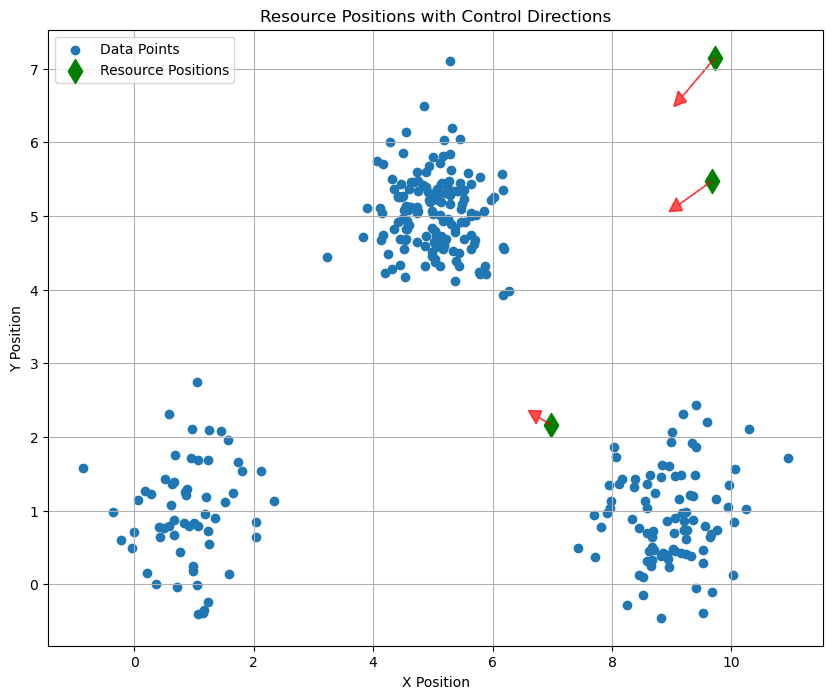

In [103]:
# Normalize the control vectors to have a length of l
l = 1
# u_y_norm = l * u_y.value / np.linalg.norm(u_y.value, axis=1, keepdims=True)
u_y_norm = u_y.value

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color="green", marker='d', s=150, label="Resource Positions")  # Resource positions

# Add arrows for control directions
for i in range(Y.shape[0]):  # Iterate over all resources
    plt.arrow(
        Y[i, 0], Y[i, 1],               # Starting point of the arrow (resource position)
        u_y_norm[i, 0], u_y_norm[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()


### Vesrion 2 - Control $y_j$

In [259]:
# Set parameters
N = total_points
q = 1/N * np.ones(N)
Px = np.diag(q)
res = 1e-6

# Fix the random seed for reproducibility
np.random.seed(42)

# Initialization of the decision variables
# Y = np.mean(X_init,axis = 0)*np.ones((m,2)) + res * np.random.rand(m,2)
# Y = 10 * np.random.rand(m,2)
Y = Y_test

In [260]:
F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)

In [261]:
# Decision variables 
u_y_v2 = cp.Variable((m,2))  
delta_v2 = cp.Variable(1)

# Constant parameters of the QP
p = 1000
gamma = 1
u_b = 0
beta = 20

# Objective: minimize the sum of squares of x and the sum of q
objective_v2 = cp.Minimize(cp.sum_squares(u_y_v2) + p * delta_v2**2)

# Define constraints
F_v2 , Fdot_v2 = F_Fdot_clustering_ver2(X_init, Y, q, u_y_v2, u_b, beta)

constraints_v2 = [
    Fdot_v2 <= -gamma * F_v2 + delta_v2,
]

# Define the problem
problem_v2 = cp.Problem(objective_v2, constraints_v2)

# Solver Options
solver_options = {
'max_iter': 20000,         # Increase max iterations to 20000
'eps_abs': 1e-4,           # Adjust absolute tolerance
'eps_rel': 1e-4,           # Adjust relative tolerance
'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
'verbose': True            # Enable verbose output to track solver progress
}

# Solve the problem
result_v2 = problem_v2.solve(solver = 'OSQP', verbose = 0)
print("Is problem quadratic?", problem.is_qp())

# Print results
print("Status:", problem_v2.status)
print("Optimal value:", problem_v2.value)
print("Optimal u_y:", np.array(u_y_v2.value))
print("Optimal delta:", np.array(delta_v2.value))

Is problem quadratic? True
Status: optimal
Optimal value: 71.12853062046865
Optimal u_y: [[-1.31665552e-01 -1.99695300e-01]
 [ 8.08820957e+00 -2.17518835e+00]
 [ 5.45802654e-03  1.04950030e-02]]
Optimal delta: [0.03034136]


In [262]:
-gamma * F_v2 + delta_v2.value - Fdot_v2.value

array([8.8817842e-16])

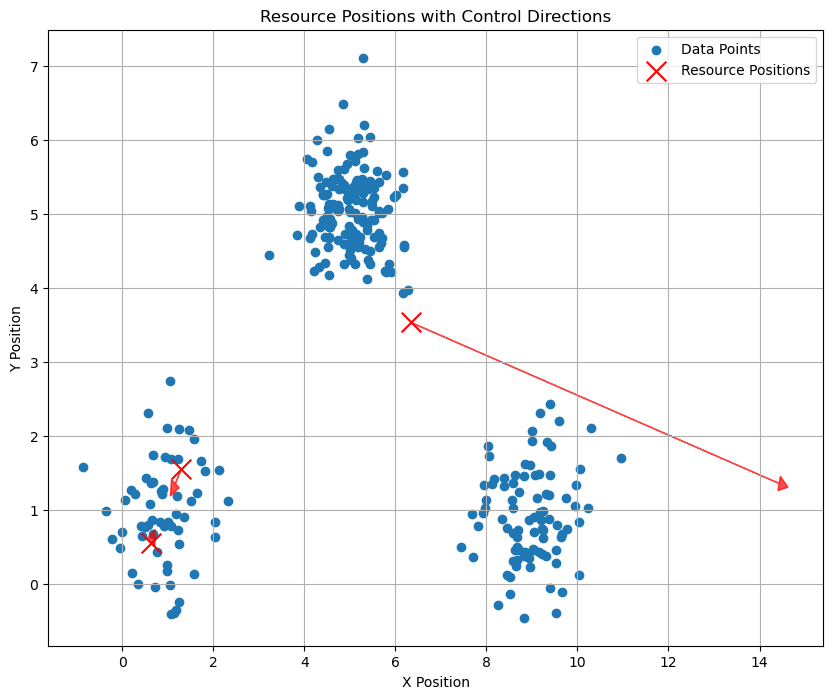

In [263]:
# Normalize the control vectors to have a length of l
l = 1
# u_y_norm = l * u_y_v2.value / np.linalg.norm(u_y_v2.value, axis=1, keepdims=True)
u_y_norm = u_y_v2.value

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color="red", label="Resource Positions", s=200, marker="x")

# Add arrows for control directions
for i in range(Y.shape[0]):  # Iterate over all resources
    plt.arrow(
        Y[i, 0], Y[i, 1],               # Starting point of the arrow (resource position)
        u_y_norm[i, 0], u_y_norm[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

In [268]:
u_y_v2.value

array([[-1.31665552e-01, -1.99695300e-01],
       [ 8.08820957e+00, -2.17518835e+00],
       [ 5.45802654e-03,  1.04950030e-02]])

### Controller

In [150]:
def control_dyn(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l):
    # Decision variables 
    u_p = cp.Variable((N,m))
    u_y = cp.Variable((m,2))  
    delta = cp.Variable(1)

    ## Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # alpha_h = 10
    #alpha_l = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }

    # Solve the problem
    result = problem.solve(solver = 'OSQP', verbose = 0)
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,2))
    else:         
        return u_p.value, u_y.value

In [151]:
# This version is for debugging and includes constraint values 
def control_dyn_debug(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l):
    # Decision variables 
    u_p = cp.Variable((N,m))
    u_y = cp.Variable((m,2))  
    delta = cp.Variable(1)

    ## Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # alpha_h = 10
    #alpha_l = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve(solver = 'OSQP', verbose = 0)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,2))
    else:         
        return u_p.value, u_y.value, F, Fdot.value, h, h_dot.value, l, l_dot.value, delta.value

In [166]:
def control_dyn_ver2(X, Y, q, beta, u_b, p, gamma):
    # Decision variables 
    u_y_v2 = cp.Variable((m,2))  
    delta_v2 = cp.Variable(1)

    # Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # u_b = 0
    # beta = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective_v2 = cp.Minimize(cp.sum_squares(u_y_v2) + p * delta_v2**2)

    # Define constraints
    F_v2 , Fdot_v2 = F_Fdot_clustering_ver2(X_init, Y, q, u_y_v2, u_b, beta)

    constraints_v2 = [
        Fdot_v2 <= -gamma * F_v2 + delta_v2,
    ]

    # Define the problem
    problem_v2 = cp.Problem(objective_v2, constraints_v2)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }

    # Solve the problem
    result_v2 = problem_v2.solve(solver = 'OSQP', verbose = 0)
    
    # Check the results
    if np.isnan(problem_v2.value).any() == True:
        print("Nan encountered!")
        return np.zeros((m,2))
    else:         
        return u_y_v2.value

## Numerical simulation

In [153]:
# Auxiliary functions to project back into the feasible space
def project_to_stochastic_matrix(matrix):
    """
    Projects each row of the input matrix onto the simplex (triangle) defined by:
    - The row sums to 1
    - Each element in the row lies within [0, 1]

    :param matrix: np.ndarray, the input matrix (shape: NxM)
    :return: np.ndarray, the projected matrix (same shape as input)
    """
    def project_to_plane(vector):
        N = vector.shape[0]
        normal = np.ones((N,))
        p = 1 / N * np.ones((N,))
        n_dot_n = N
        v_dot_n = np.dot(vector, normal)
        p_dot_n = np.dot(p, normal)
        projection = vector - ((v_dot_n - p_dot_n) / n_dot_n) * normal
        return projection

    def project_to_triangle(v):
        tol = 1e-7
        v_proj = project_to_plane(v)
        v_clamped = np.clip(v_proj, tol, 1 - tol)
        sum_clamped = np.sum(v_clamped)

        if sum_clamped == 1:
            return v_clamped
        elif sum_clamped < 1:
            deficit = 1 - sum_clamped
            free_indices = v_clamped < 1
            num_free = np.sum(free_indices)
            if num_free > 0:
                increment = deficit / num_free
                v_clamped[free_indices] += increment
            return v_clamped
        else:
            return v_clamped / sum_clamped

    # Apply the projection to each row of the matrix
    projected_matrix = np.apply_along_axis(project_to_triangle, axis=1, arr=matrix)
    return projected_matrix

In [154]:
# Fix the random seed for reproducibility
np.random.seed(42)

# Simulation parameters
T_f = 10 # Total time
dt = 0.001  # Time step
times = np.arange(0, T_f, dt)  # Time vector
Y_traj = np.zeros((m,2,len(times)))
P_traj = np.zeros((N,m,len(times)))
u_y_traj = np.zeros((m,2,len(times)))
u_p_traj = np.zeros((N,m,len(times)))
beta_traj = np.zeros(len(times))

q = 1/N * np.ones(N)
Px = np.diag(q)
pert = 1e-6

# Initialization of the decision variables
# Y0 = np.mean(X_init,axis = 0)*np.ones((m,2))
# Y = Y0 + pert * np.random.rand(m,2)
Y = np.ones((m,2))

P_ylx = np.random.rand(N, m)
P_ylx = P_ylx / P_ylx.sum(axis=1, keepdims=True)
# P_ylx = 1/m * np.ones((N,m))

Py = np.sum(Px @ P_ylx, axis = 0)
c = 1 * np.ones(m) + pert

# Setting the coefficients
alpha_h = 20
alpha_l = 20
p = 1000
gamma = 10
beta = 10
u_b = 0

run_time_cvx = []
print('beta = ', beta)

beta =  10


In [ ]:
u_p, u_y, F, Fdot, h, hdot, l, ldot, delta = control_dyn_debug(X_init, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l)
print("Ineq Constraint 1 - Elements between 0 and 1: ", np.min(hdot + alpha_h * h))
print("Ineq Constraint 2 - Capacity constraint: ", np.min(ldot + alpha_l * l))
print("Ineq Constraint 3 - Stability: ", -gamma * F + delta - Fdot)
print("Eq Constraint 4 - Rows of u_p must sum up to 0: ", np.max(np.abs(np.sum(u_p, axis=1))))

Ineq Constraint 1 - Elements between 0 and 1:  0.0739303486003491
Ineq Constraint 2 - Capacity constraint:  13.039543078012944
Ineq Constraint 3 - Stability:  [-4.26325641e-14]
Eq Constraint 4 - Rows of u_p must sum up to 0:  4.336808689942018e-19


In [401]:
# Simulate the system
tol = 10e-15
Free_energy = []
beta_array = []

for t in range(len(times)):  # start from 1 because 0 is initial condition
    # Store the state
    Y_traj[:,:,t] = Y
    P_traj[:,:,t] = P_ylx
    
    Free_energy.append(Free_Energy(X_init, Y, q, P_ylx, beta)) # Store the free energy at each time
    
    start_time = time.time()
    u_p, u_y = control_dyn(X_init, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l)
    end_time = time.time()
    run_time_cvx.append(end_time - start_time)
    beta_array.append(beta)
    
    Y += u_y * dt  # Update x
    P_ylx += P_ylx * dt  # Update Q
    P_ylx = project_to_stochastic_matrix(P_ylx) # project into the feasible set
    beta += u_b * dt

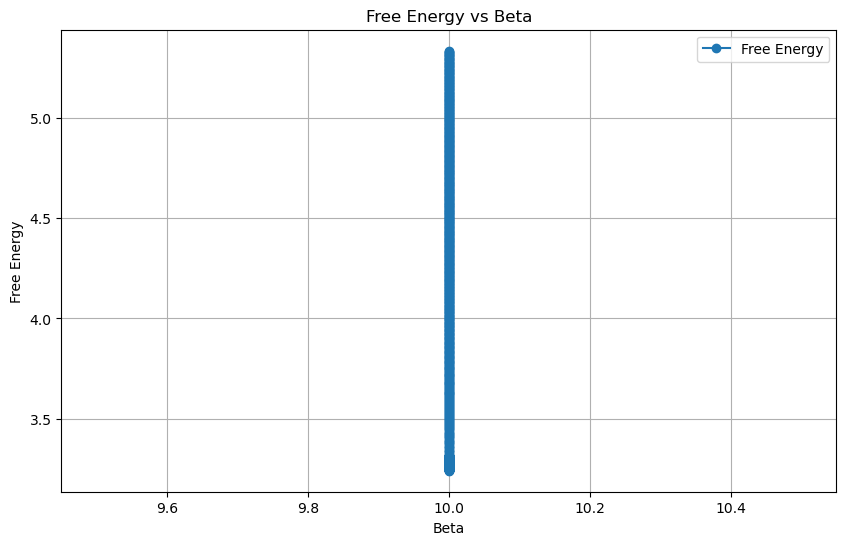

In [402]:
# Plot Free Energy vs. Beta
plt.figure(figsize=(10, 6))
plt.plot(beta_array, Free_energy, marker='o', label='Free Energy')
plt.title("Free Energy vs Beta")
plt.xlabel("Beta")
plt.ylabel("Free Energy")
plt.grid(True)
plt.legend()
plt.show()

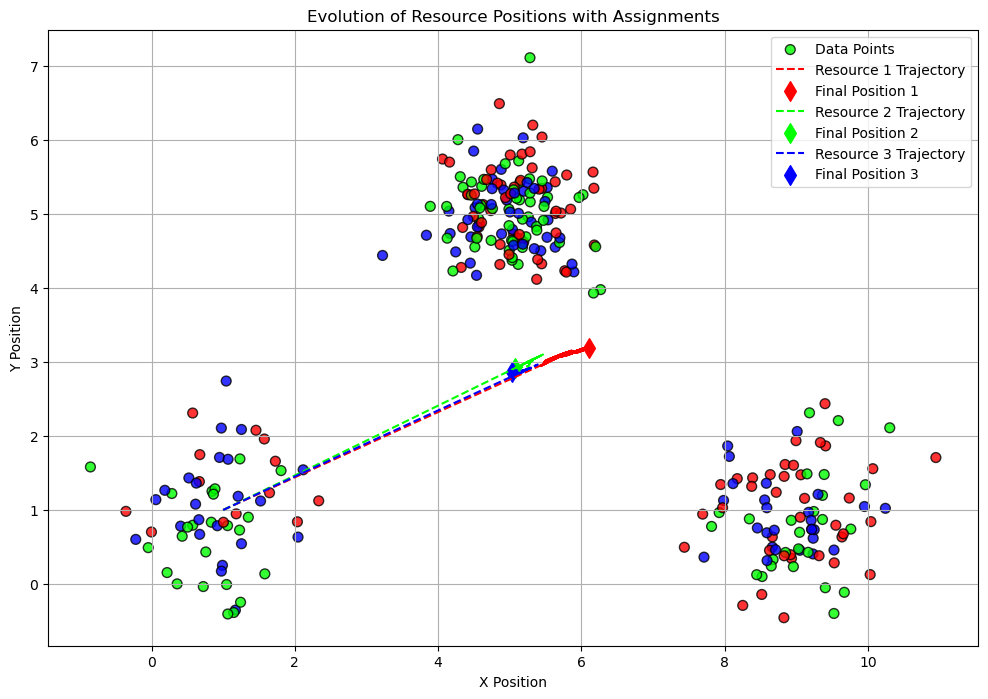

In [408]:
# Define a color for each resource (RGB values)
resource_colors = np.array([
    [1, 0, 0],  # Red for resource 1
    [0, 1, 0],  # Green for resource 2
    [0, 0, 1],  # Blue for resource 3
])

# Compute colors for each data point
data_colors = np.dot(P_ylx, resource_colors)  # Weighted sum of resource colors

# Plot setup
plt.figure(figsize=(12, 8))

# Plot data points with computed colors
plt.scatter(
    X_init[:, 0], X_init[:, 1],
    c=data_colors, s=50, edgecolor='k', alpha=0.8, label="Data Points"
)

# Plot trajectories and final positions of resources
for i in range(m):
    plt.plot(
        Y_traj[i, 0, :], Y_traj[i, 1, :],
        label=f"Resource {i+1} Trajectory", linestyle="--", color=resource_colors[i]
    )
    # Mark final positions of resources
    plt.scatter(
        Y_traj[i, 0, -1], Y_traj[i, 1, -1],
        marker="d", s=100, color=resource_colors[i], label=f"Final Position {i+1}"
    )

# Customize the plot
plt.title("Evolution of Resource Positions with Assignments")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

In [404]:
Y_traj[:,:,-1]

array([[6.10899257, 3.19270504],
       [5.07008336, 2.92009287],
       [5.03330384, 2.86431722]])

In [405]:
P_traj[:,:,-1]

array([[9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999800e-01, 9.99999900e-08, 9.99999900e-08],
       [9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999800e-01, 9.99999900e-08, 9.99999900e-08],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999800e-01, 9.99999900e-08, 9.99999900e-08],
       [9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999800e-01, 9.99999900e-08],
       [9.99999800e-01, 9.99999900e-08, 9.99999900e-08],
       [9.99999900e-08, 9.99999900e-08, 9.99999800e-01],
       [9.99999900e-08, 9.99999

### Version 2 - Control $y_j$

In [498]:
# Fix the random seed for reproducibility
np.random.seed(17)

# Simulation parameters
T_f = 10 # Total time
dt = 0.001  # Time step
times = np.arange(0, T_f, dt)  # Time vector
Y_traj = np.zeros((m,2,len(times)))
u_y_traj = np.zeros((m,2,len(times)))
beta_traj = np.zeros(len(times))

q = 1/N * np.ones(N)
Px = np.diag(q)
pert = 1e-10

# Initialization of the decision variables
Y0 = np.mean(X_init,axis = 0)*np.ones((m,2))
# Y = Y0 + pert * np.random.rand(m,2)
Y = np.ones((m,2)) + pert * np.random.rand(m,2)
# Y = 10 * np.random.rand(m,2)
# Y = Y_test

# Setting the coefficients
p = 1000
gamma = 1
beta = 0.1
u_b = 1

run_time_cvx = []
print('beta = ', beta)

beta =  0.1


In [499]:
# Simulate the system
tol = 10e-15
Free_energy = []
Fdot = []
beta_array = []

for t in range(len(times)): 
    # Compute the free energy
    # Free_energy.append(Free_Energy_ver2(X_init, Y, q, beta)) # Store the free energy at each time
    
    start_time = time.time()
    u_y = control_dyn_ver2(X_init, Y, q, beta, u_b, p, gamma)
    end_time = time.time()
    run_time_cvx.append(end_time - start_time)
    beta_array.append(beta)

    # Store the state and control
    Y_traj[:,:,t] = Y
    u_y_traj[:,:,t] = u_y

    # Compute the free energy and its time derivative
    F_frame, Fdot_frame = F_Fdot_clustering_ver2(X_init, Y, q, u_y, u_b, beta)
    Free_energy.append(F_frame) # Store the free energy at each time
    Fdot.append(Fdot_frame.value) # Store the time derivative of the free energy at each time

    
    Y += u_y * dt # Update Y
    beta += u_b * dt # Increase beta

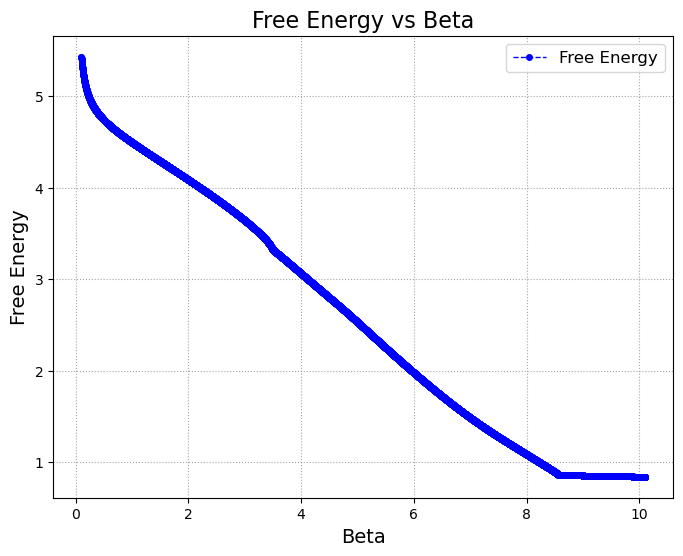

In [500]:
# Plot Free Energy vs. Beta
plt.figure(figsize=(8,6))  # Adjust the figure size

# Customizing the line and markers
plt.plot(
    beta_array, Free_energy,
    color="blue", linestyle="--", linewidth=1, marker=".", markersize=8, label="Free Energy"
)

# Adding labels, title, and grid
plt.title("Free Energy vs Beta", fontsize=16)
plt.xlabel("Beta", fontsize=14)
plt.ylabel("Free Energy", fontsize=14)
plt.grid(color="gray", linestyle=":", linewidth=0.8, alpha=0.7)

# Customizing the legend
plt.legend(fontsize=12, loc="upper right")

# Show the plot
plt.show()


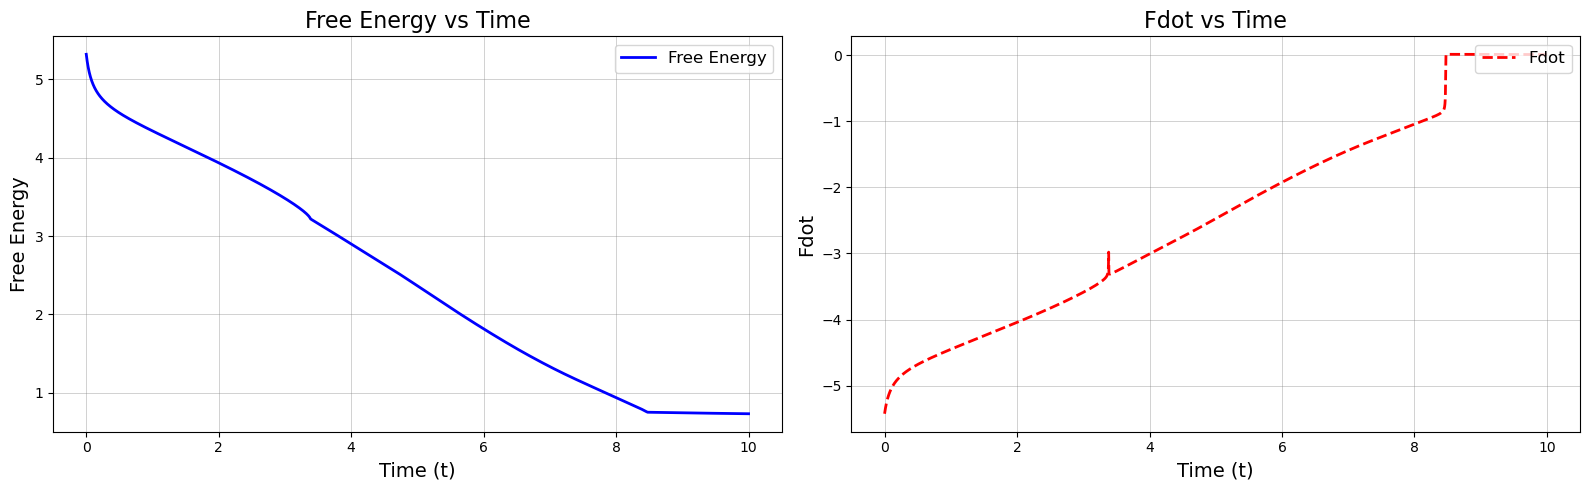

In [501]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16,5))  # Two subplots, one column

# Plot Free Energy vs. Time in the first subplot
axs[0].plot(
    times, Free_energy - 1/beta * np.log(m),
    color="blue", linestyle="-", linewidth=2, label="Free Energy"
)
axs[0].set_title("Free Energy vs Time", fontsize=16)
axs[0].set_xlabel("Time (t)", fontsize=14)
axs[0].set_ylabel("Free Energy", fontsize=14)
axs[0].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[0].legend(fontsize=12, loc="upper right")

# Plot Fdot vs. Time in the second subplot
axs[1].plot(
    times, Fdot,
    color="red", linestyle="--", linewidth=2, label="Fdot"
)
axs[1].set_title("Fdot vs Time", fontsize=16)
axs[1].set_xlabel("Time (t)", fontsize=14)
axs[1].set_ylabel("Fdot", fontsize=14)
axs[1].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[1].legend(fontsize=12, loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [502]:
ind = -1 # Frame index
F_frame, Fdot_frame = F_Fdot_clustering_ver2(X_init, Y_traj[:,:,ind], q, u_y_traj[:,:,ind], u_b, beta_array[ind])
print('F = ', F_frame - 1/beta * np.log(m), 'and Fdot = ', Fdot_frame.value)

F =  0.7327701785908804 and Fdot =  0.009124439872799983


In [503]:
X_expanded_f = np.expand_dims(X_init, 1)       # Shape (N, 1, 2)
Y_expanded_f = np.expand_dims(Y_traj[:,:,ind], 0)       # Shape (1, m, 2)
# Y_expanded_f = np.expand_dims(np.mean(X_init,axis = 0)*np.ones((m,2)), 0)       # Shape (1, m, 2)
distances_f = np.sqrt(np.sum((X_expanded_f - Y_expanded_f) ** 2, axis=2))
distances_n_f = distances_f - np.min(distances_f, axis = 1).reshape(-1,1)
Px = np.diag(q)
beta_f = beta_array[ind]
P_ylx_G_f = np.exp(-beta_f * distances_n_f)/(np.sum(np.exp(-beta_f * distances_n_f),axis = 1).reshape(-1,1))
Py_f = np.sum(Px @ P_ylx_G_f, axis = 0)
dFdY_f = 2 * (Py_f[:, np.newaxis] * Y - P_ylx_G_f.T @ Px @ X_init)
print('dF/dY = ', dFdY_f)

dF/dY =  [[ 0.00000000e+00  0.00000000e+00]
 [ 8.04911693e-15  1.20459198e-14]
 [-1.77635684e-15  1.11022302e-15]]


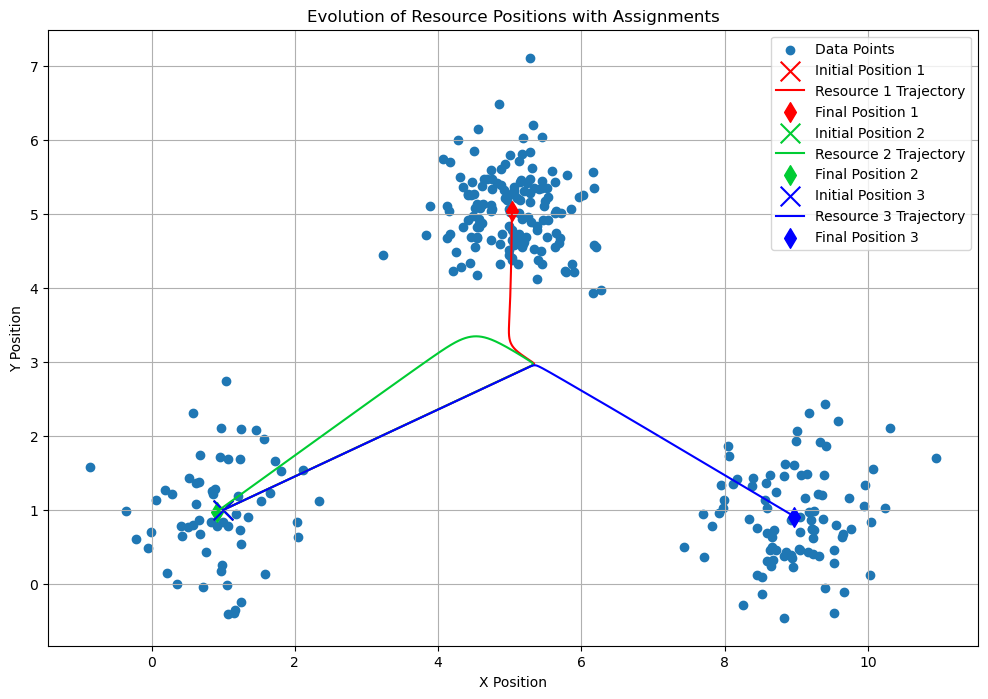

In [509]:
# Define a color for each resource (RGB values)
resource_colors = np.array([
    [1, 0, 0],  # Red for resource 1
    [0, 0.8, 0.2],  # Green for resource 2
    [0, 0, 1],  # Blue for resource 3
])

# Plot setup
plt.figure(figsize=(12, 8))

# Plot data points with computed colors
plt.scatter(X_init[:, 0], X_init[:, 1], label="Data Points")

# Plot trajectories and final positions of resources
for i in range(m):
    # Mark initial positions of resources
    plt.scatter(
        Y_traj[i, 0, 0], Y_traj[i, 1, 0],
        marker="x", s=200, color=resource_colors[i], label=f"Initial Position {i+1}"
    )
    plt.plot(
        Y_traj[i, 0, :], Y_traj[i, 1, :],
        label=f"Resource {i+1} Trajectory", linestyle="-", color=resource_colors[i]
    )
    # Mark final positions of resources
    plt.scatter(
        Y_traj[i, 0, -1], Y_traj[i, 1, -1],
        marker="d", s=100, color=resource_colors[i], label=f"Final Position {i+1}"
    )

# Customize the plot
plt.title("Evolution of Resource Positions with Assignments")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("resource_positions.png", dpi=300, bbox_inches='tight')

In [505]:
Y_test = Y_traj[:,:,-1]

In [506]:
Y_test

array([[5.02930076, 5.03570908],
       [0.91158564, 0.97645241],
       [8.97359549, 0.91105199]])

### Plot frames

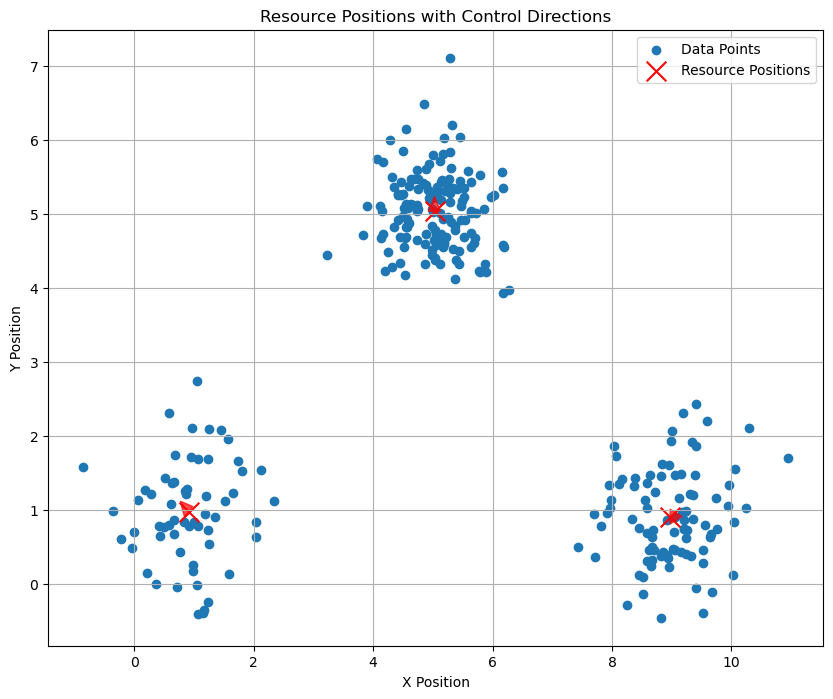

In [494]:
ind = -2 # Frame index

# Normalize the control vectors to have a length of l
l = 1
# u_y_frame = l * u_y_traj[:,:,ind] / np.linalg.norm(u_y_traj[:,:,ind], axis=1, keepdims=True)
u_y_frame = u_y_traj[:,:,ind]

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y_traj[:, 0, ind], Y_traj[:, 1, ind], color="red", label="Resource Positions", s=200, marker="x")

# Add arrows for control directions
for i in range(Y_traj[:,:,ind].shape[0]):  # Iterate over all resources
    plt.arrow(
        Y_traj[i,0,ind], Y_traj[i,1,ind],               # Starting point of the arrow (resource position)
        u_y_frame[i, 0], u_y_frame[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

## Test

In [264]:
np.random.rand(m,2)

array([[0.37454012, 0.95071431],
       [0.73199394, 0.59865848],
       [0.15601864, 0.15599452]])

In [214]:
u_p = cp.Parameter((N,m))
u_p.value = np.ones((N,m))/2

In [256]:
F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)

In [222]:
l, ldot  = l_ldot(c, q, P_ylx, u_p)

In [223]:
ldot.value

array([-0.5, -0.5, -0.5])

In [257]:
F

20.126406742356508

In [177]:
np.dot(q, P_yx)

array([0.33333333, 0.33333333, 0.33333333])

In [204]:
cp.sum(U, axis = 1).value

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [43]:
m = 3
Y = np.mean(X_init,axis = 0)*np.ones((m,2))
N = np.shape(X_init)[0]
beta = 0.01
pert = 10e-10
Y += pert * (np.arange(m)+1).reshape(-1,1) * np.ones((m,2))
X_expanded = np.expand_dims(X_init, 1)  # Shape (N, 1, 2)
Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)

# Compute the squared differences, sum over the coordinate axis (axis=2), and take the square root
distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
Y_c = P_xy.T @ X_init

In [130]:
Px = (1/N) * np.eye(N)
Py = np.sum(Px @ P_yx, axis = 0)
F = np.sum(Px @ np.multiply(P_yx, distances + 1/beta * np.log(P_yx)))
dFdY = 2 * (Py[:, np.newaxis] * Y - P_yx.T @ Px @ X_init)
dotF_y = cp.sum(cp.multiply(dFdY,u_y)).value

In [46]:
distances.shape

(300, 3)

In [153]:
distances + 1/beta * np.log(P_yx) + 1/beta

array([[-5.31722544, -5.31722544, -5.31722544],
       [-5.82632351, -5.82632351, -5.82632351],
       [-4.82379565, -4.82379565, -4.82379565],
       [-6.28449891, -6.28449891, -6.28449891],
       [-4.87555055, -4.87555055, -4.87555055],
       [-4.60666863, -4.60666863, -4.60666863],
       [-4.48141354, -4.48141354, -4.48141354],
       [-3.7668234 , -3.7668234 , -3.7668234 ],
       [-4.45975458, -4.45975458, -4.45975458],
       [-4.01118509, -4.01118509, -4.01118509],
       [-5.88049801, -5.88049801, -5.88049801],
       [-4.58767686, -4.58767686, -4.58767686],
       [-4.72007359, -4.72007359, -4.72007359],
       [-4.38112377, -4.38112377, -4.38112377],
       [-4.57158608, -4.57158608, -4.57158608],
       [-4.9993877 , -4.9993877 , -4.9993877 ],
       [-4.68200085, -4.68200085, -4.68200085],
       [-5.10545485, -5.10545485, -5.10545485],
       [-4.44269104, -4.44269104, -4.44269104],
       [-4.22188092, -4.22188092, -4.22188092],
       [-5.56798038, -5.56798038, -5.567

In [182]:
u = cp.parameter()
u.value = np.ones((N,2))

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [115]:
dFdY = 2 * (Py[:, np.newaxis] * Y - P_yx.T @ Px @ X_init)

In [129]:
np.sum(np.multiply(dFdY, u))

2.5261940539422767e-08

In [212]:
x = cp variable()

Expression(AFFINE, UNKNOWN, (906,))

In [183]:
U = cp.Parameter((N, 2))  # Define a parameter of size (2m x 2)
U.value = np.ones((N,2))  # Set its value (shape 2m x 2)

In [188]:
q

array([0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
       0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333

In [191]:
(q[:,np.newaxis].T @ U).value

array([[1., 1.]])

In [151]:
cp.sum(cp.multiply(dFdY,U)).value

2.5261940539422767e-08

In [127]:
(cp.vec(dFdY.flatten()) @ U).value

2.5261940539422767e-08

In [118]:
U = cp.vec(u.T)

In [120]:
U.value

array([0., 1., 2., 3., 4., 5.])

In [123]:
cp.parameter(dFdY) @ U

AttributeError: module 'cvxpy' has no attribute 'parameter'

In [58]:
Px = (1/N) * np.eye(N)
np.sum(Px @ P_yx, axis = 0)

array([0.33333333, 0.33333333, 0.33333333])

In [54]:
distances

array([[4.54400342, 4.54400342, 4.54400342],
       [4.03490536, 4.03490536, 4.03490536],
       [5.03743322, 5.03743322, 5.03743322],
       [3.57672995, 3.57672995, 3.57672995],
       [4.98567831, 4.98567831, 4.98567831],
       [5.25456023, 5.25456023, 5.25456023],
       [5.37981532, 5.37981533, 5.37981533],
       [6.09440547, 6.09440547, 6.09440547],
       [5.40147428, 5.40147429, 5.40147429],
       [5.85004377, 5.85004377, 5.85004377],
       [3.98073086, 3.98073086, 3.98073086],
       [5.273552  , 5.27355201, 5.27355201],
       [5.14115528, 5.14115528, 5.14115528],
       [5.48010509, 5.4801051 , 5.4801051 ],
       [5.28964278, 5.28964279, 5.28964279],
       [4.86184117, 4.86184117, 4.86184117],
       [5.17922801, 5.17922802, 5.17922802],
       [4.75577401, 4.75577401, 4.75577401],
       [5.41853782, 5.41853782, 5.41853783],
       [5.63934795, 5.63934795, 5.63934795],
       [4.29324849, 4.29324849, 4.29324849],
       [4.98251843, 4.98251843, 4.98251843],
       [5.

In [63]:
np.sum(Px @ np.multiply(P_yx, distances + 1/beta * np.log(P_yx)))

-106.53607030541917

In [64]:
(-1/beta/N) * np.sum(np.log(np.sum(np.exp(-beta * distances),axis = 1)))

-106.53607030541914

In [65]:
Y.flatten()

array([5.38904616, 2.98646062, 5.38904616, 2.98646062, 5.38904616,
       2.98646062])

In [79]:
X_test = X_init.reshape(N,-1,2)
Y_test = Y.reshape(m,-1,2)

In [80]:
differences_tensor = X_init[:, np.newaxis, :] - Y[np.newaxis, :, :]

In [74]:
X_init[10,:]

array([2.03637018, 0.84035205])

In [81]:
differences_tensor.shape

(300, 3, 2)

In [88]:
test_qq = 2 * np.sum((Px @ P_yx)[:, :, np.newaxis] * differences_tensor, axis = 0)

In [90]:
test_qq

array([[-6.76748785e-10, -6.74438880e-10],
       [-1.33333515e-09, -1.33333214e-09],
       [-1.98992094e-09, -1.99222525e-09]])

In [92]:
Py = np.sum(Px @ P_yx, axis = 0)

In [97]:
Py[:, np.newaxis] * Y

array([[1.79634872, 0.99548687],
       [1.79634872, 0.99548687],
       [1.79634872, 0.99548687]])

In [104]:
P_yx.T @ Px @ X_init

array([[1.79634872, 0.99548687],
       [1.79634872, 0.99548687],
       [1.79634872, 0.99548687]])

In [105]:
2 * (Py[:, np.newaxis] * Y - P_yx.T @ Px @ X_init)

array([[6.76751544e-10, 6.74439615e-10],
       [1.33334677e-09, 1.33333833e-09],
       [1.98991845e-09, 1.99222372e-09]])